# Estimation de Pose 3D par Transfert Learning avec ResNet50
# Analyse des Erreurs de Pose 
## Par: Julian CAIPA.
### Pour: Computer Vision, M. ABABSA.


### Étape 1 : Préparation des données

In [2]:
import os
import numpy as np

train_path = "office\seq-01" 
test_path = "office\seq-01"  

def load_pose_data(folder):
    images = []
    poses = []
    
    for file in sorted(os.listdir(folder)):
        if file.endswith(".pose.txt"):
            pose_path = os.path.join(folder, file)
            pose_matrix = np.loadtxt(pose_path).reshape((4, 4))
            
            position = pose_matrix[:3, 3]
            rotation = pose_matrix[:3, :3].flatten()
            
            pose_vector = np.concatenate((position, rotation))
            poses.append(pose_vector)
            
            img_name = file.replace(".pose.txt", ".color.png")
            img_path = os.path.join(folder, img_name)
            images.append(img_path)
    
    return images, np.array(poses)

train_images, train_poses = load_pose_data(train_path)
test_images, test_poses = load_pose_data(test_path)

print("Training data:")
print(f"Number of images: {len(train_images)}")
print(f"Pose dimensions: {train_poses.shape}")

print("\nTest data:")
print(f"Number of images: {len(test_images)}")
print(f"Pose dimensions: {test_poses.shape}")


Training data:
Number of images: 1000
Pose dimensions: (1000, 12)

Test data:
Number of images: 1000
Pose dimensions: (1000, 12)


### Étape 2 : Configuration de ResNet50 pour l’estimation de pose

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
output_layer = Dense(12, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Print the model summary
# model.summary()


### Étape 3 : Entraînement du modèle

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint


def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=(224, 224)) 
        img_array = img_to_array(img)
        img_array = img_array / 255.0 
        images.append(img_array)
    return np.array(images)

train_images_processed = preprocess_images(train_images) 
test_images_processed = preprocess_images(test_images) 

epochs = 15  
batch_size = 10  

checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

history = model.fit(
    x=train_images_processed,  
    y=train_poses,             
    validation_data=(test_images_processed, test_poses),  
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint],
    verbose=1
)

import pickle
with open("training_history.pkl", "wb") as file:
    pickle.dump(history.history, file)

print("Training completed and history saved!")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 42.3980 - mae: 2.6840
Epoch 1: val_loss improved from inf to 1098.42407, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - loss: 42.0919 - mae: 2.6678 - val_loss: 1098.4241 - val_mae: 27.5237
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0363 - mae: 0.1457
Epoch 2: val_loss improved from 1098.42407 to 0.25338, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - loss: 0.0362 - mae: 0.1455 - val_loss: 0.2534 - val_mae: 0.4188
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0217 - mae: 0.1113
Epoch 3: val_loss did not improve from 0.25338
100/100 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - loss: 0.0217 - mae: 0.1113 - val_loss: 0.3341 - val_mae: 0.4767
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0146 - mae: 0.0936
Epoch 4: val_loss did not improve from 0.25338
100/100 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - loss: 0.0146 - mae: 0.0936 - val_loss: 0

### Étape 4 : Prédiction et Calcul des Erreurs

In [5]:
import numpy as np

predicted_poses = model.predict(test_images_processed)

real_positions = test_poses[:, :3]  
predicted_positions = predicted_poses[:, :3]  

real_rotations = test_poses[:, 3:].reshape(-1, 3, 3)  
predicted_rotations = predicted_poses[:, 3:].reshape(-1, 3, 3)  

position_errors = np.linalg.norm(real_positions - predicted_positions, axis=1)

orientation_errors = [
    np.linalg.norm(real - pred, ord='fro')  # Frobenius norm
    for real, pred in zip(real_rotations, predicted_rotations)
]

# Step 5: Display average errors
print("Position Errors (Euclidean distance):")
print(f"Mean: {np.mean(position_errors):.4f}, Std: {np.std(position_errors):.4f}")

print("Orientation Errors (Frobenius norm):")
print(f"Mean: {np.mean(orientation_errors):.4f}, Std: {np.std(orientation_errors):.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
Position Errors (Euclidean distance):
Mean: 0.1042, Std: 0.0513
Orientation Errors (Frobenius norm):
Mean: 0.1676, Std: 0.0617


### Étape 5 : Analyse Statistique des Erreurs

In [6]:
import pandas as pd

position_stats = {
    "Mean": np.mean(position_errors),
    "Std Dev": np.std(position_errors),
    "Median": np.median(position_errors),
    "Min": np.min(position_errors),
    "Max": np.max(position_errors)}

orientation_stats = {
    "Mean": np.mean(orientation_errors),
    "Std Dev": np.std(orientation_errors),
    "Median": np.median(orientation_errors),
    "Min": np.min(orientation_errors),
    "Max": np.max(orientation_errors)}

position_table = pd.DataFrame([position_stats], index=["Position Errors"])
orientation_table = pd.DataFrame([orientation_stats], index=["Orientation Errors"])

print("\nPosition Error Statistics:")
print(position_table)

print("\nOrientation Error Statistics:")
print(orientation_table)

position_table.to_csv("position_error_stats.csv")
orientation_table.to_csv("orientation_error_stats.csv")



Position Error Statistics:
                    Mean   Std Dev    Median       Min       Max
Position Errors  0.10421  0.051262  0.096876  0.009463  0.297653

Orientation Error Statistics:
                        Mean   Std Dev    Median       Min       Max
Orientation Errors  0.167585  0.061739  0.161794  0.045821  0.406171


### Étape 6 : Visualisation des Erreurs avec des Graphiques


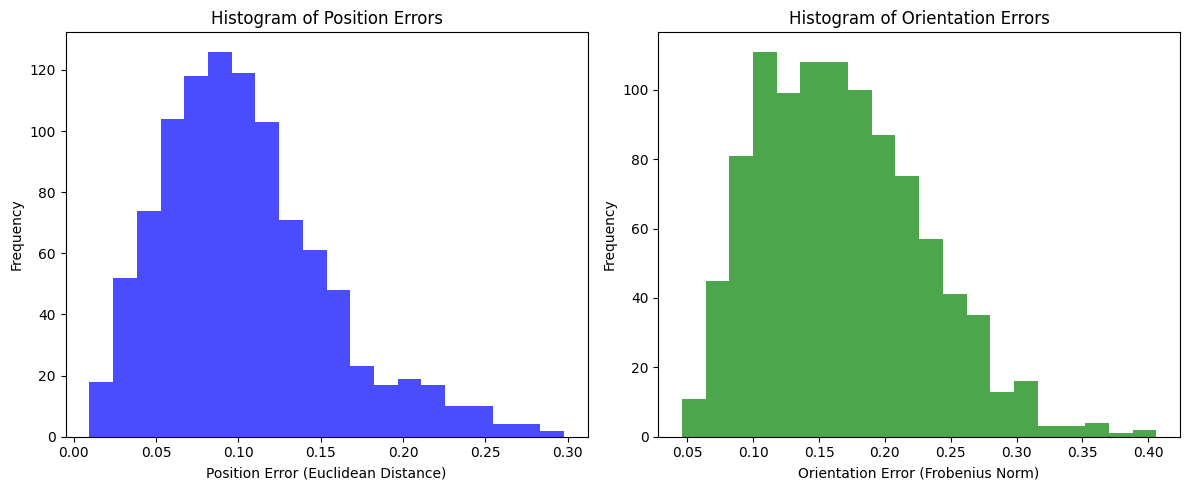

C:\Users\equip\AppData\Local\Temp\ipykernel_6448\2868620012.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([position_errors, orientation_errors], vert=True, patch_artist=True, labels=["Position", "Orientation"])


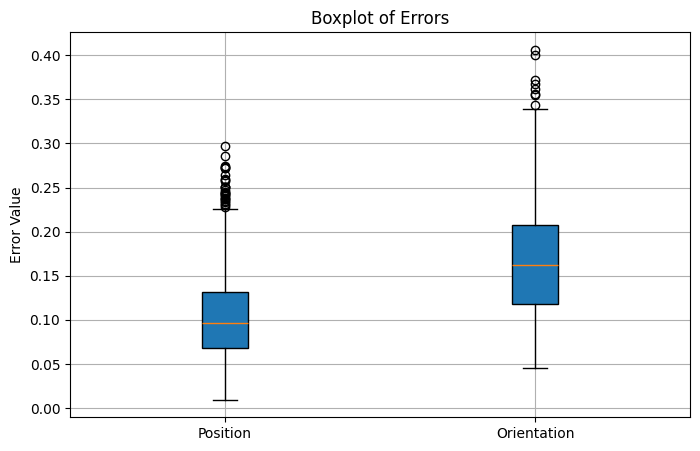

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(position_errors, bins=20, color='blue', alpha=0.7)
plt.title("Histogram of Position Errors")
plt.xlabel("Position Error (Euclidean Distance)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(orientation_errors, bins=20, color='green', alpha=0.7)
plt.title("Histogram of Orientation Errors")
plt.xlabel("Orientation Error (Frobenius Norm)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))

plt.boxplot([position_errors, orientation_errors], vert=True, patch_artist=True, labels=["Position", "Orientation"])
plt.title("Boxplot of Errors")
plt.ylabel("Error Value")
plt.grid(True)

plt.show()

### Étape 7 : Approximation des Erreurs par un Mélange de Gaussiennes

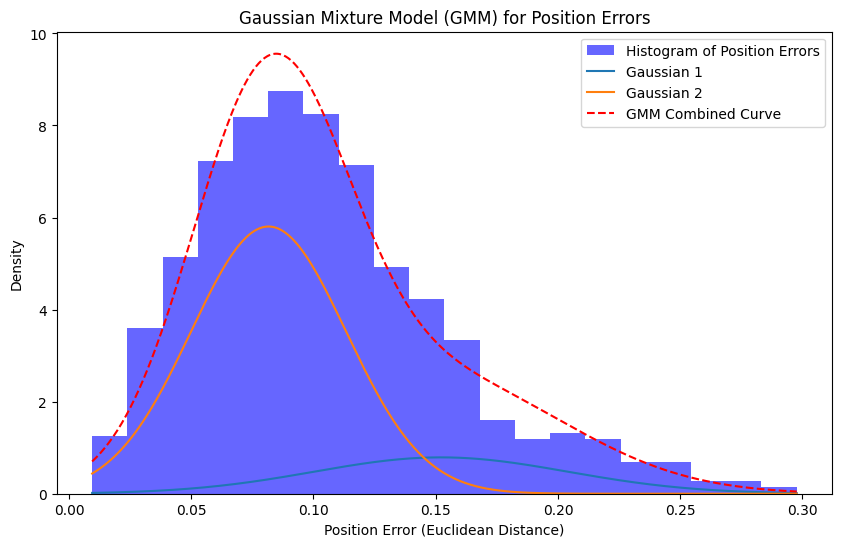

In [11]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

n_components = 2  
gmm = GaussianMixture(n_components=n_components, random_state=42)
position_errors_reshaped = position_errors.reshape(-1, 1)  
gmm.fit(position_errors_reshaped)

x = np.linspace(min(position_errors), max(position_errors), 500).reshape(-1, 1)  
gaussian_curves = np.exp(gmm.score_samples(x))  

plt.figure(figsize=(10, 6))

plt.hist(position_errors, bins=20, density=True, color='blue', alpha=0.6, label="Histogram of Position Errors")

for i in range(n_components):
    plt.plot(x, gmm.weights_[i] * np.exp(gmm._estimate_weighted_log_prob(x)[:, i]), label=f"Gaussian {i+1}")

plt.plot(x, gaussian_curves, color='red', linestyle='--', label="GMM Combined Curve")

plt.title("Gaussian Mixture Model (GMM) for Position Errors")
plt.xlabel("Position Error (Euclidean Distance)")
plt.ylabel("Density")
plt.legend()
plt.show()

### Annexe 1 : BIC

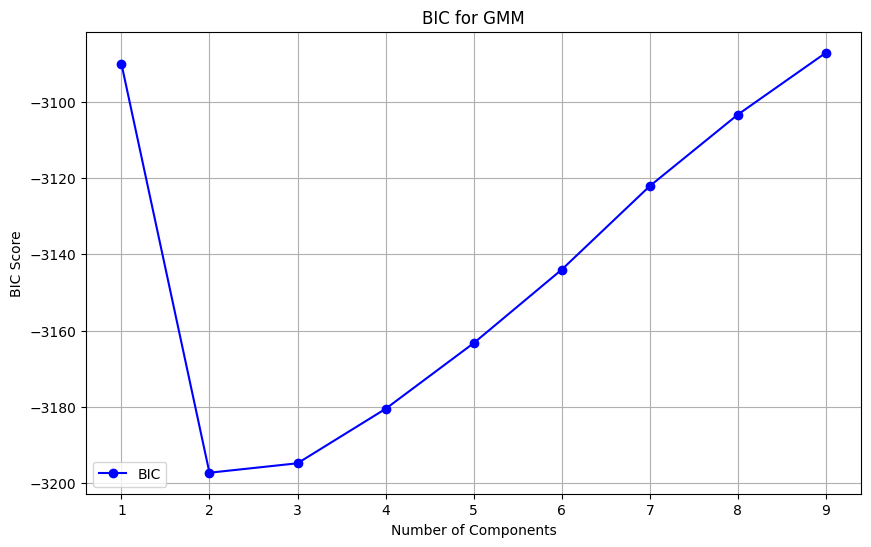

Optimal number of components (BIC): 2


In [9]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

bic_scores = []
n_components_range = range(1, 10)  

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)  
    gmm.fit(position_errors.reshape(-1, 1))  
    bic_scores.append(gmm.bic(position_errors.reshape(-1, 1)))  

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, label="BIC", marker='o', color='blue')
plt.xlabel("Number of Components")
plt.ylabel("BIC Score")
plt.title("BIC for GMM")
plt.legend()
plt.grid(True)
plt.show()

optimal_components_bic = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components (BIC): {optimal_components_bic}")